<a href="https://colab.research.google.com/github/FleaBusyBeeBergs/dtsa5506-pipeline/blob/main/statcan_etl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# file handling
import pandas as pd
import os
from google.colab import files
import xml.etree.ElementTree as ET

# http requests
import requests

# vis
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split


## ETL pipeline

Stats can has tools to make http requests for date from their cube. [1]

In [2]:
# Base URL for data extraction
BASE_URL = 'https://www150.statcan.gc.ca/t1/wds/sdmx/statcan/rest/vector/'

I was able to make a request for a single vector, but needed help with transforming the XML output that was extracted. I spent a lot of time trying to write a loop to extract and parse multiple vectors, and ended up using a code generator [2] for the following StatCanETL class:

In [3]:
# Namespace mappings for XML parsing
NAMESPACES = {
    "message": "http://www.sdmx.org/resources/sdmxml/schemas/v2_1/message",
    "generic": "http://www.sdmx.org/resources/sdmxml/schemas/v2_1/data/generic",
    "common": "http://www.sdmx.org/resources/sdmxml/schemas/v2_1/common",
}


In [10]:
class StatCanETL:
    def __init__(self, table_df):
        # Initialize with the DataFrame of table metadata
        self.table_df = table_df
        self.data_objects = {}  # Dictionary to store DataFrames dynamically

    def extract(self, vector, start_period, end_period):
        """Extract data from the StatCan API for a given vector."""
        url = f"{BASE_URL}{vector}?startPeriod={start_period}&endPeriod={end_period}&detail=full"
        response = requests.get(url)

        if response.status_code == 200:
            return response.content
        else:
            raise ValueError(f"Failed to fetch data for vector {vector}. HTTP Status: {response.status_code}")

    def transform(self, xml_content, frequency):
        """Transform the XML response into a structured DataFrame."""
        # Parse XML content
        root = ET.fromstring(xml_content)

        # Locate the Series element
        series = root.find(".//generic:Series", NAMESPACES)
        if series is None:
            raise ValueError("No Series element found in the XML response.")

        # Extract observations
        observations = series.findall(".//generic:Obs", NAMESPACES)
        data = []
        for obs in observations:
            obs_dim = obs.find(".//generic:ObsDimension", NAMESPACES)
            obs_val = obs.find(".//generic:ObsValue", NAMESPACES)
            date = obs_dim.attrib["value"]

            # Convert date format if the frequency is quarterly
            if frequency == 'quarterly':
                date = self.convert_quarter_to_date(date)
            elif frequency == 'yearly':
                date = date[:4] + '-01'

            data.append({
                "Date": date,
                "Value": float(obs_val.attrib["value"]),
            })

        # Convert to DataFrame
        df = pd.DataFrame(data)
        return df

    @staticmethod
    def convert_quarter_to_date(quarter_str):
        """Convert a quarterly date string (YYYY-Qx) to a standard date format (YYYY-MM)."""
        try:
            year, quarter = quarter_str.split("-Q")
            quarter_start_month = {
                "1": "01",
                "2": "04",
                "3": "07",
                "4": "10",
            }.get(quarter)
            if quarter_start_month:
                return f"{year}-{quarter_start_month}"
            else:
                raise ValueError(f"Invalid quarter format: {quarter_str}")
        except Exception as e:
            raise ValueError(f"Error converting quarter string {quarter_str}: {e}")

    def load(self, df, name):
        """Load the DataFrame into an object named name_df."""
        variable_name = f"{name}_df"
        globals()[variable_name] = df  # Dynamically create a global variable
        self.data_objects[variable_name] = df  # Store in a dictionary for easy access
        print(f"Data for {name} saved to object {variable_name}")

    def run(self):
        """Run the full ETL pipeline for all variables."""
        for _, row in self.table_df.iterrows():
            print(f"Processing {row['name']}...")
            try:
                # Extract
                xml_content = self.extract(row["vector"], row["start"], row["end"])

                # Transform
                df = self.transform(xml_content, row["frequency"])

                # Load
                self.load(df, row["name"])
            except Exception as e:
                print(f"Error processing {row['name']}: {e}")

In [11]:
# Define the table metadata
tables = {
    'name': ['wage', 'raw', 'tax', 'productivity', 'cpi'],
    'tableid': [14100223, 18100268, 11100058, 36100206, 18100004],
    'vector': ['v79311153', 'v1230998135', 'v122807833', 'v1409153', 'v41690973'],
    'description': ['', '', '', '', ''],
    'frequency': ['monthly', 'monthly', 'yearly', 'quarterly', 'monthly'],
    'start': ['2001-01', '2001-01', '2001-01', '2001-Q1', '2001-01'],
    'end': ['2024-12', '2024-12', '2024-12', '2024-Q4', '2024-12'],
    'url': ['', '', '', '', '']
}

# Create DataFrame
table_df = pd.DataFrame(tables)

In [12]:
# Initialize and run the ETL pipeline
pipeline = StatCanETL(table_df)
pipeline.run()

Processing wage...
Data for wage saved to object wage_df
Processing raw...
Data for raw saved to object raw_df
Processing tax...
Data for tax saved to object tax_df
Processing productivity...
Data for productivity saved to object productivity_df
Processing cpi...
Data for cpi saved to object cpi_df


## EDA

**check to see if the data loaded correctly:**

In [13]:
for key, value in pipeline.data_objects.items():
    print(key)
    print(value.head(3))

wage_df
      Date   Value
0  2001-01  657.14
1  2001-02  653.59
2  2001-03  655.14
raw_df
      Date  Value
0  2001-01   65.2
1  2001-02   65.8
2  2001-03   65.5
tax_df
      Date  Value
0  2001-01   14.0
1  2002-01   13.8
2  2003-01   13.8
productivity_df
      Date   Value
0  2001-01  85.173
1  2001-04  86.150
2  2001-07  86.665
cpi_df
      Date  Value
0  2001-01   96.3
1  2001-02   96.8
2  2001-03   97.1


Rename columns

In [14]:
wage_df.rename(columns = {'Value': 'wage'}, inplace = True)
raw_df.rename(columns = {'Value': 'raw'}, inplace = True)
tax_df.rename(columns = {'Value': 'tax'}, inplace = True)
productivity_df.rename(columns = {'Value': 'productivity'}, inplace = True)
cpi_df.rename(columns={'Value': 'cpi'}, inplace = True)

Merge tables

In [15]:
data = wage_df.merge(raw_df, on = 'Date', how = 'outer') \
                .merge(tax_df, on = 'Date', how = 'outer') \
                .merge(productivity_df, on = 'Date', how = 'outer') \
                .merge(cpi_df, on = 'Date', how = 'outer')

Because productivity has quarterly observations and tax has yearly observations, the NaN values need to be dealt with.

In [16]:
data = data.fillna(method = 'ffill')

In [ ]:
scaler = StandardScaler()
imputer = SimpleImputer(strategy = 'mean')

In [17]:
data

,Date,wage,raw,tax,productivity,cpi
0,2001-01,657.14,65.2,14.0,85.173,96.3
1,2001-02,653.59,65.8,14.0,85.173,96.8
2,2001-03,655.14,65.5,14.0,85.173,97.1
3,2001-04,652.44,65.2,14.0,86.150,97.8
4,2001-05,652.28,65.3,14.0,86.150,98.6
...,...,...,...,...,...,...
283,2024-08,1274.25,139.3,13.0,101.372,161.8
284,2024-09,1277.70,134.9,13.0,101.372,161.1
285,2024-10,1284.43,140.3,13.0,101.372,161.8
286,2024-11,NaN,139.6,13.0,101.372,161.8


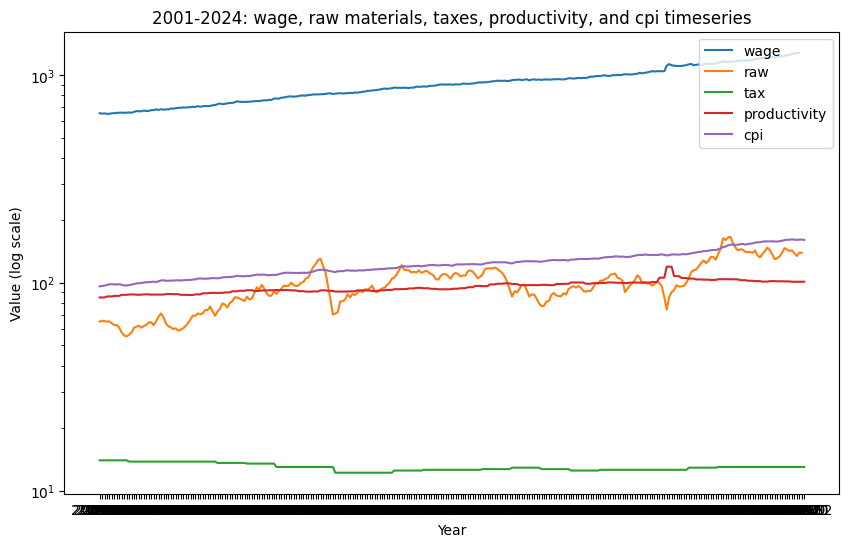

In [18]:
plt.figure(figsize=(10, 6))

for var in data.columns[1:]:
    plt.plot(data['Date'], data[var], label = var)
plt.yscale('log')
plt.xlabel('Year')
plt.xticks()
plt.ylabel('Value (log scale)')
plt.title('2001-2024: wage, raw materials, taxes, productivity, and cpi timeseries')
plt.legend()


In [19]:
data_2001_2010 = data[data['Date'].between('2001-01-01', '2010-12-01')]
data_2011_2020 = data[data['Date'].between('2011-01-01', '2020-12-01')]
data_2015_2024 = data[data['Date'].between('2015-01-01', '2024-12-01')]

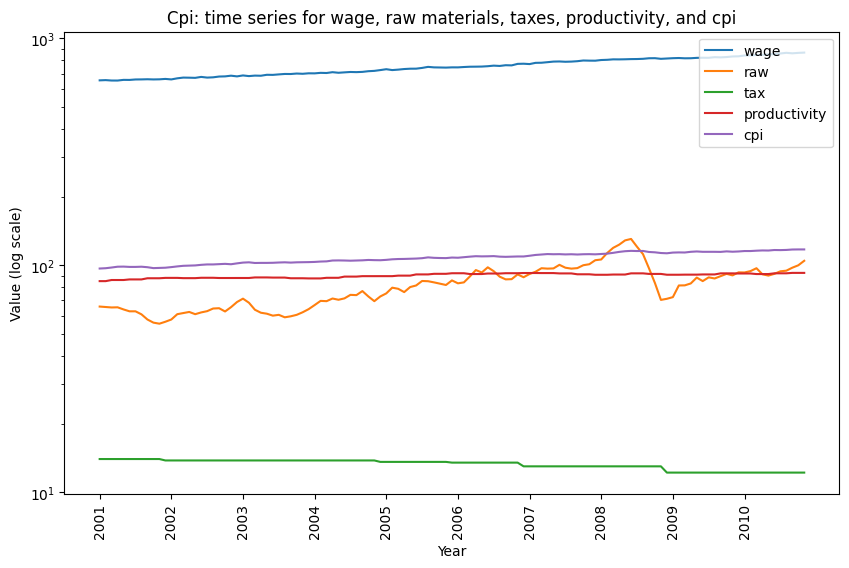

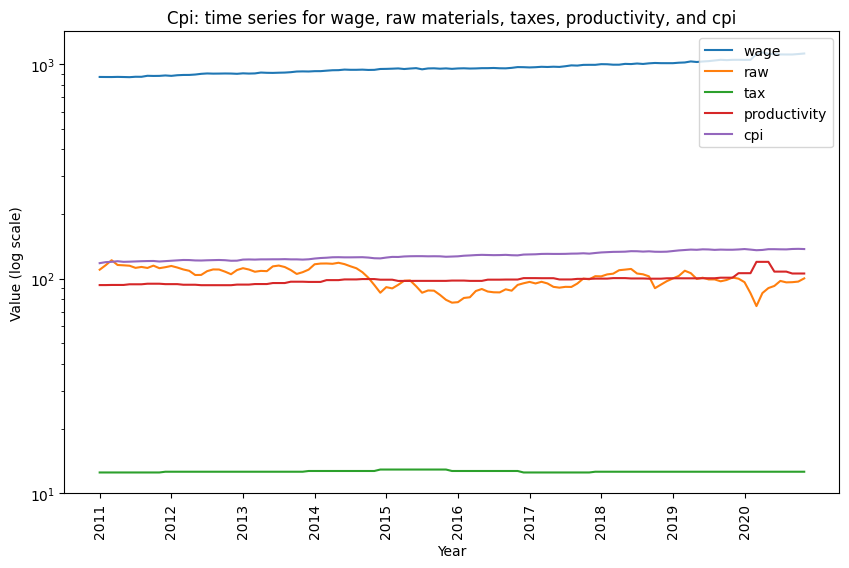

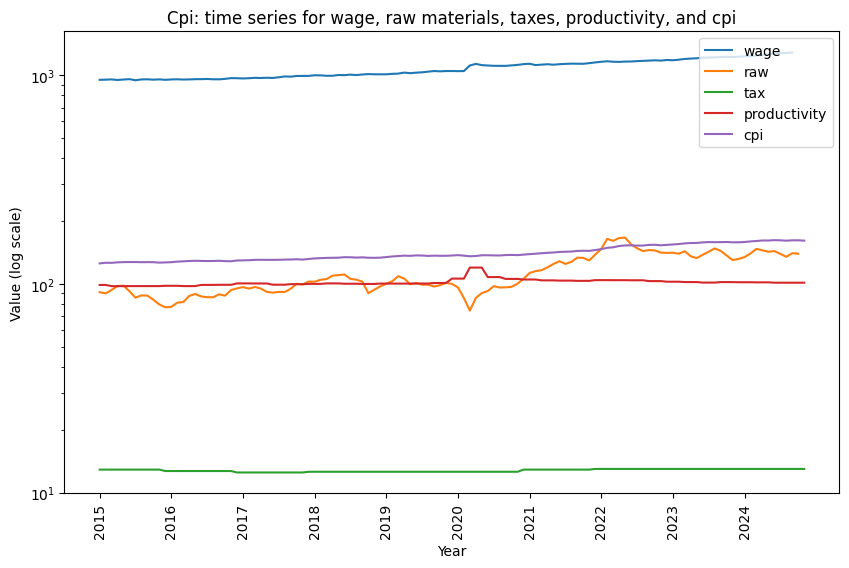

In [27]:
timespans = [data_2001_2010, data_2011_2020, data_2015_2024]

for timespan in timespans:
    plt.figure(figsize = (10, 6))

    for var in timespan.columns[1:]:
        plt.plot(timespan['Date'], timespan[var], label = var)
        plt.yscale('log')
        plt.xlabel('Year')

        x_tick_labels = [pd.to_datetime(d).year for d in timespan['Date'][::12]]

        plt.xticks(timespan['Date'][::12], x_tick_labels, rotation = 90)
        plt.ylabel('Value (log scale)')

        # df names
        df_name = var.replace('_', ' ')
        df_name = df_name.title()

        plt.title(f'{df_name}: time series for wage, raw materials, taxes, productivity, and cpi')
        plt.legend()

## References

1. [Statistics Canada SDMX userguide](https://www.statcan.gc.ca/en/developers/sdmx/user-guide)
2. [OpenAI](https://chatgpt.com/)